Correlation between GitBug-Java and Defects4J costs: 0.9614
P-value: 0.0000


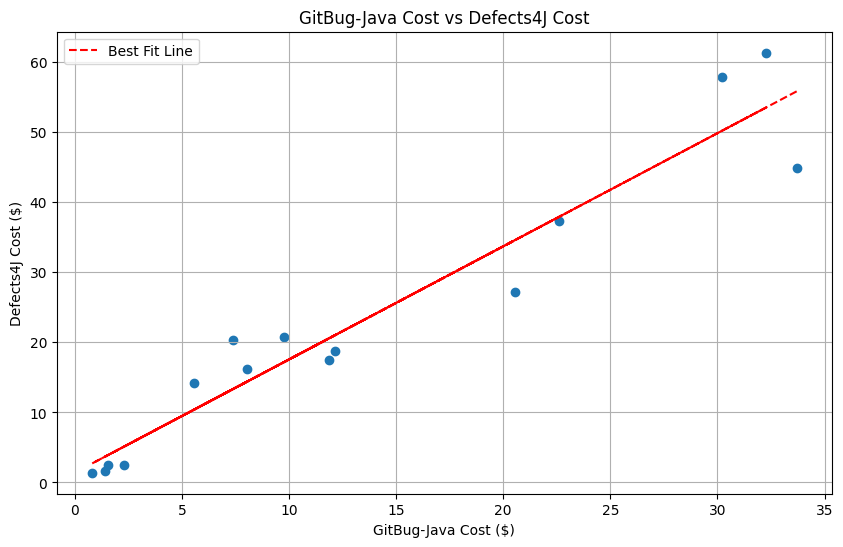

Best fit line equation: y = 1.62x + 1.41
For a GitBug-Java cost of $100.00, the predicted Defects4J cost is $162.91


In [1]:
import json
import os
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def load_data(results_dir):
    data = []
    with open("../models.json") as f:
        model_list = json.load(f)["models"]
    benchmarks = ['defects4j', 'gitbugjava']
    metrics = ['ast_match@1', 'plausible@1']

    for llm_name, strategy, provider in model_list:
        row = {'name': llm_name, 'provider': provider, 'total_cost': 0}

        try:
            with open(f"{results_dir}/{llm_name}/total.json") as f:
                total_result = json.load(f)
                row['total_ast_match@1'] = total_result.get('ast_match@1', None)
                row['total_plausible@1'] = total_result.get('plausible@1', None)
                row['total_cost'] = total_result.get('cost', 0)
                row['total_num_bugs_with_ast_match_candidates'] = total_result.get('num_bugs_with_ast_match_candidates', 0)
                row['total_num_bugs_with_plausible_candidates'] = total_result.get('num_bugs_with_plausible_candidates', 0)
                row['total_greedy_ast_match@10'] = row['total_num_bugs_with_ast_match_candidates'] / 574
                row['total_greedy_plausible@10'] = row['total_num_bugs_with_plausible_candidates'] / 574
        except FileNotFoundError:
            print(f"Warning: total.json not found for {llm_name}")
            row['total_ast_match@1'] = None
            row['total_plausible@1'] = None

        for benchmark in benchmarks:
            try:
                with open(f"{results_dir}/{llm_name}/{benchmark}/statistics_{benchmark}_instruct_{strategy}.json") as f:
                    stats_result = json.load(f)
                    for metric in metrics:
                        row[f"{benchmark}_{metric}"] = stats_result.get(metric, None)

                with open(f"{results_dir}/{llm_name}/{benchmark}/costs_{benchmark}_instruct_{strategy}.json") as f:
                    cost_result = json.load(f)
                    row[f"{benchmark}_cost"] = cost_result.get('total_cost', 0)
                    row['total_cost'] += cost_result.get('total_cost', 0)
            except FileNotFoundError:
                print(f"Warning: Data not found for {llm_name} - {benchmark}")
                for metric in metrics:
                    row[f"{benchmark}_{metric}"] = None
                row[f"{benchmark}_cost"] = None

        data.append(row)

    return data

# Load the data
results_dir = os.path.join("..", 'results')
data = load_data(results_dir)

# Create a DataFrame
df = pd.DataFrame(data)

# Extract GitBug-Java and Defects4J costs
gitbug_costs = df['gitbugjava_cost'].dropna()
defects4j_costs = df['defects4j_cost'].dropna()

# Ensure we have matching data for both benchmarks
common_indices = gitbug_costs.index.intersection(defects4j_costs.index)
gitbug_costs = gitbug_costs[common_indices]
defects4j_costs = defects4j_costs[common_indices]

# Compute correlation
correlation, p_value = stats.pearsonr(gitbug_costs, defects4j_costs)

print(f"Correlation between GitBug-Java and Defects4J costs: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(gitbug_costs, defects4j_costs)
plt.xlabel('GitBug-Java Cost ($)')
plt.ylabel('Defects4J Cost ($)')
plt.title('GitBug-Java Cost vs Defects4J Cost')

# Add a best fit line
m, b = np.polyfit(gitbug_costs, defects4j_costs, 1)
plt.plot(gitbug_costs, m*gitbug_costs + b, color='red', linestyle='--', label='Best Fit Line')

plt.legend()
plt.grid(True)
plt.show()

# Print the equation of the best fit line
print(f"Best fit line equation: y = {m:.2f}x + {b:.2f}")

# Predict Defects4J cost based on GitBug-Java cost
gitbug_cost = 100  # Example cost for GitBug-Java
predicted_defects4j_cost = m * gitbug_cost + b
print(f"For a GitBug-Java cost of ${gitbug_cost:.2f}, the predicted Defects4J cost is ${predicted_defects4j_cost:.2f}")

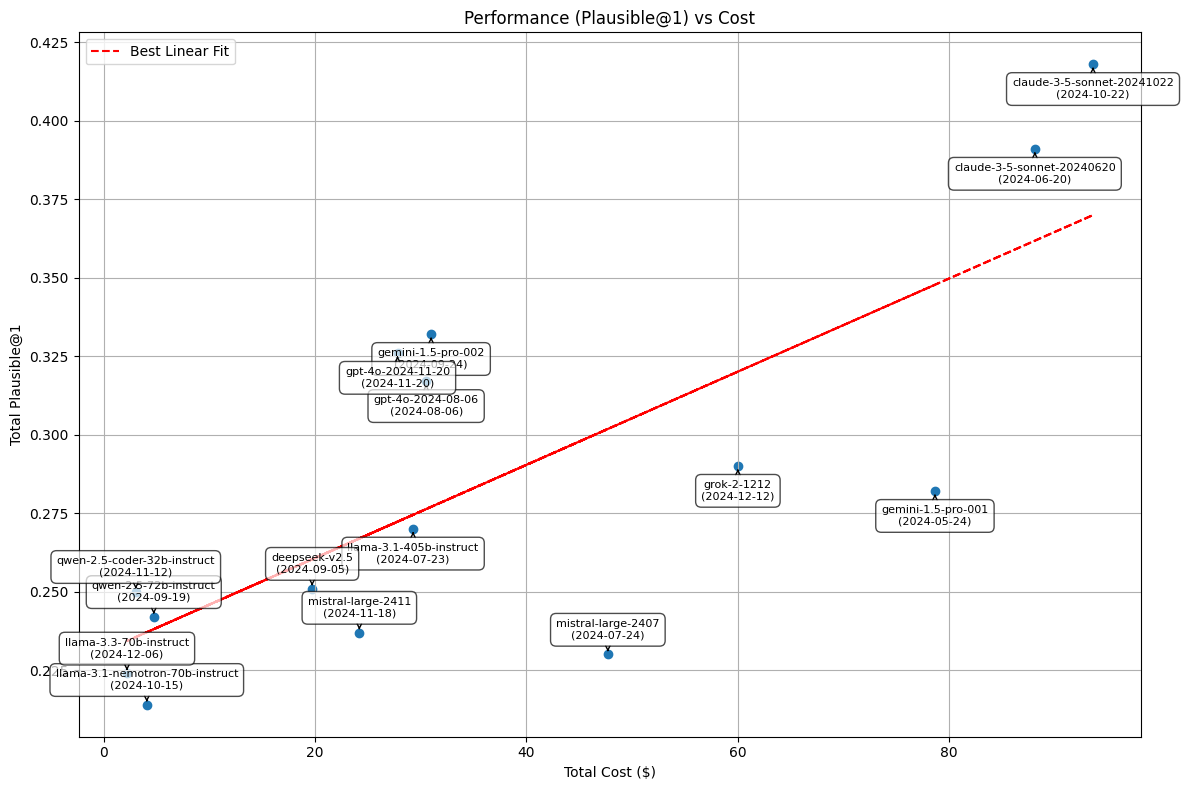

Best fit line equation: y = 0.001484x + 0.2310
Correlation between Total Cost and Total Plausible@1: 0.7494
P-value: 0.0013


In [2]:
# Create a scatter plot of performance per cost
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['total_cost'], df['total_plausible@1'])

# Define a dictionary with release dates for each model
with open('../results/release_dates.json') as f:
    release_dates = json.load(f)

# Drop rows with missing data
df_total = df.dropna(subset=['total_cost', 'total_plausible@1'])

# Add labels for each point with release dates
for i, row in df_total.iterrows():
    model_name = row['name']
    release_date = release_dates.get(model_name, 'N/A')
    
    label = f"{model_name}\n({release_date})"
    x, y = row['total_cost'], row['total_plausible@1']
    
    # Adjust the position of the label to stay within the plot
    ha = 'center'
    va = 'bottom' if y < df_total['total_plausible@1'].median() else 'top'
    xytext = (0, 10) if va == 'bottom' else (0, -10)
    
    plt.annotate(label, (x, y), 
                 xytext=xytext, textcoords='offset points', 
                 ha=ha, va=va, fontsize=8, 
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.xlabel('Total Cost ($)')
plt.ylabel('Total Plausible@1')
plt.title('Performance (Plausible@1) vs Cost')

# Add a best fit line
m, b = np.polyfit(df_total['total_cost'], df_total['total_plausible@1'], 1)
plt.plot(df_total['total_cost'], m*df_total['total_cost'] + b, color='red', linestyle='--', label='Best Linear Fit')

plt.legend()
plt.grid(True)

# Adjust the plot layout to make room for annotations
plt.tight_layout()

# Save as pdf
plt.savefig('performance-vs-cost.pdf', format='pdf', bbox_inches='tight')
plt.savefig('performance-vs-cost.png', format='png', bbox_inches='tight')

plt.show()

# Print the equation of the best fit line
print(f"Best fit line equation: y = {m:.6f}x + {b:.4f}")

# Calculate and print correlation
correlation, p_value = stats.pearsonr(df_total['total_cost'], df_total['total_plausible@1'])
print(f"Correlation between Total Cost and Total Plausible@1: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

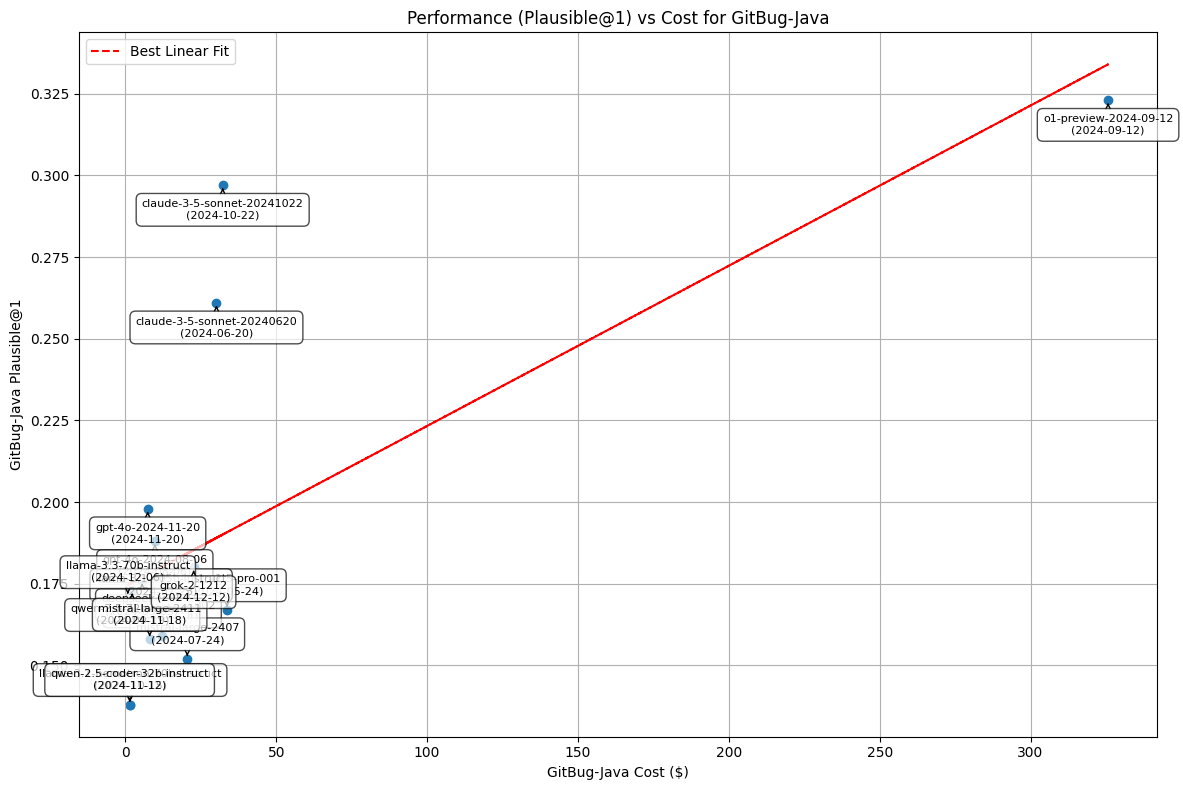

Best fit line equation: y = 0.000490x + 0.1743
Correlation between GitBug-Java Cost and GitBug-Java Plausible@1: 0.7056
P-value: 0.0023


In [3]:
# Create a scatter plot of performance per cost
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['gitbugjava_cost'], df['gitbugjava_plausible@1'])

# Define a dictionary with release dates for each model
with open('../results/release_dates.json') as f:
    release_dates = json.load(f)

# Add labels for each point with release dates
for i, row in df.iterrows():
    model_name = row['name']
    release_date = release_dates.get(model_name, 'N/A')
    
    label = f"{model_name}\n({release_date})"
    x, y = row['gitbugjava_cost'], row['gitbugjava_plausible@1']
    
    # Adjust the position of the label to stay within the plot
    ha = 'center'
    va = 'bottom' if y < df['gitbugjava_plausible@1'].median() else 'top'
    xytext = (0, 10) if va == 'bottom' else (0, -10)
    
    plt.annotate(label, (x, y), 
                 xytext=xytext, textcoords='offset points', 
                 ha=ha, va=va, fontsize=8, 
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.xlabel('GitBug-Java Cost ($)')
plt.ylabel('GitBug-Java Plausible@1')
plt.title('Performance (Plausible@1) vs Cost for GitBug-Java')

# Add a best fit line
m, b = np.polyfit(df['gitbugjava_cost'], df['gitbugjava_plausible@1'], 1)
plt.plot(df['gitbugjava_cost'], m*df['gitbugjava_cost'] + b, color='red', linestyle='--', label='Best Linear Fit')

plt.legend()
plt.grid(True)

# Adjust the plot layout to make room for annotations
plt.tight_layout()

# Save as pdf
plt.savefig('performance-vs-cost-gitbugjava.pdf', format='pdf', bbox_inches='tight')
plt.savefig('performance-vs-cost-gitbugjava.png', format='png', bbox_inches='tight')

plt.show()

# Print the equation of the best fit line
print(f"Best fit line equation: y = {m:.6f}x + {b:.4f}")

# Calculate and print correlation
correlation, p_value = stats.pearsonr(df['gitbugjava_cost'], df['gitbugjava_plausible@1'])
print(f"Correlation between GitBug-Java Cost and GitBug-Java Plausible@1: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

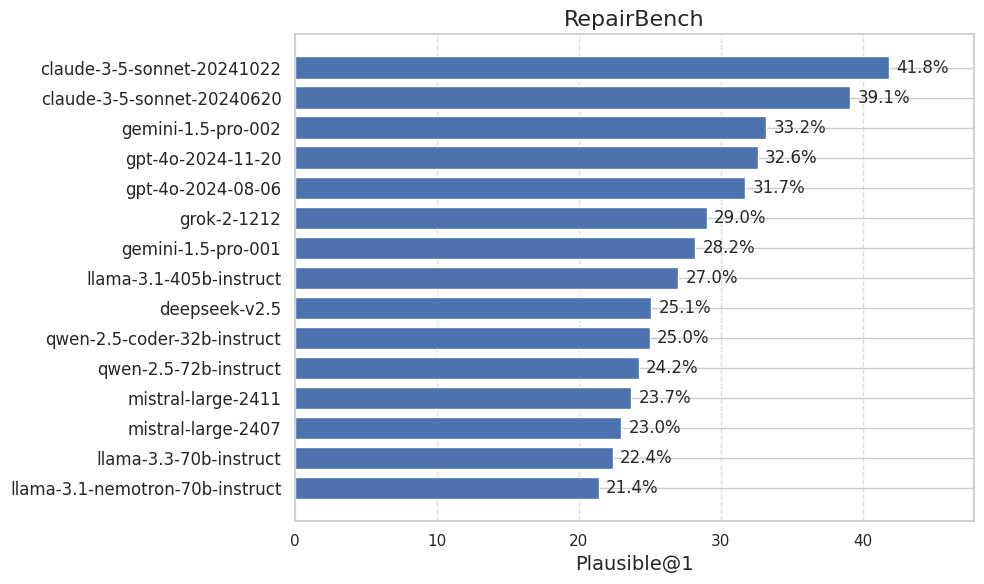

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the DataFrame by 'total_plausible@1' in descending order
df_sorted = df.sort_values(by='total_plausible@1', ascending=True)

# Remove rows with missing data
df_sorted = df_sorted.dropna(subset=['total_plausible@1'])

# Set a style
sns.set(style="whitegrid")

# Create a horizontal bar plot with a single color
plt.figure(figsize=(10, 6))
bars = plt.barh(df_sorted['name'], df_sorted['total_plausible@1'] * 100, align="center", height=0.75)  # Reduced height

# Set labels and title with improved font size and bold text
plt.xlabel('Plausible@1', fontsize=14)
plt.title('RepairBench', fontsize=16)

# Add text annotations to display the exact score at the end of each bar with some space and bold text
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.1f}%', va='center', fontsize=12)

# Adjust x-axis limits to provide extra space on the right side
plt.xlim(0, df_sorted['total_plausible@1'].max() * 100 + 6)

# Add a grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Make the names bold
plt.yticks(fontsize=12)

# Adjust layout to make room for the labels
plt.tight_layout()

# Save as pdf
plt.savefig('box-plot.pdf', format='pdf', bbox_inches='tight')
plt.savefig('box-plot.png', format='png', bbox_inches='tight')

# Display the plot
plt.show()

/tmp/ipykernel_79228/601099907.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


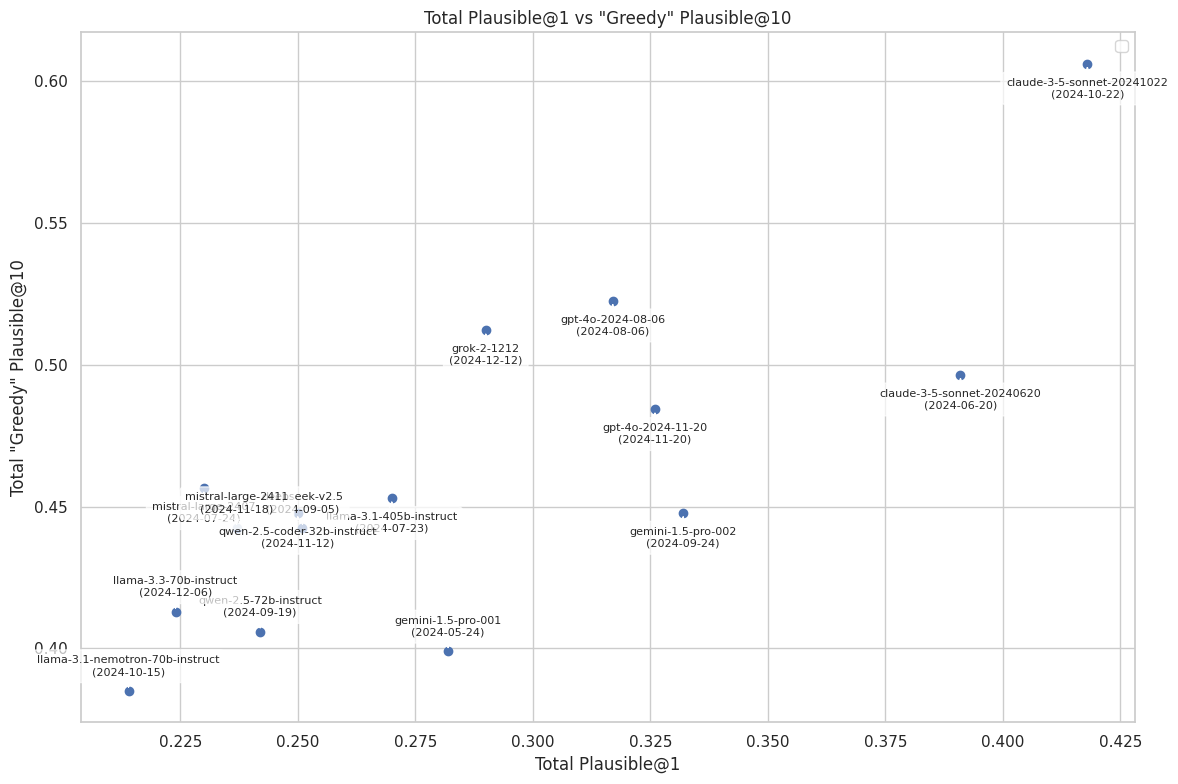

Best fit line equation: y = 0.000490x + 0.1743
Correlation between Total Plausible@1 and Greedy Plausible@10: 0.7968
P-value: 0.0004


In [5]:
# Create a scatter plot of pass@1 vs "greedy" pass@10
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['total_plausible@1'], df['total_greedy_plausible@10'])

# Define a dictionary with release dates for each model
with open('../results/release_dates.json') as f:
    release_dates = json.load(f)

# Drop rows with missing data
df_total = df.dropna(subset=['total_plausible@1', 'total_greedy_plausible@10'])

# Add labels for each point with release dates
for i, row in df_total.iterrows():
    model_name = row['name']
    release_date = release_dates.get(model_name, 'N/A')
    
    label = f"{model_name}\n({release_date})"
    x, y = row['total_plausible@1'], row['total_greedy_plausible@10']
    
    # Adjust the position of the label to stay within the plot
    ha = 'center'
    va = 'bottom' if y < df_total['total_greedy_plausible@10'].median() else 'top'
    xytext = (0, 10) if va == 'bottom' else (0, -10)
    
    plt.annotate(label, (x, y), 
                 xytext=xytext, textcoords='offset points', 
                 ha=ha, va=va, fontsize=8, 
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.xlabel('Total Plausible@1')
plt.ylabel('Total "Greedy" Plausible@10')
plt.title('Total Plausible@1 vs "Greedy" Plausible@10')

plt.legend()
plt.grid(True)

# Adjust the plot layout to make room for annotations
plt.tight_layout()

# Save as pdf
plt.savefig('pass@1-vs-greedy-pass@10.pdf', format='pdf', bbox_inches='tight')
plt.savefig('pass@1-vs-greedy-pass@10.png', format='png', bbox_inches='tight')

plt.show()

# Print the equation of the best fit line
print(f"Best fit line equation: y = {m:.6f}x + {b:.4f}")

# Calculate and print correlation
correlation, p_value = stats.pearsonr(df_total['total_plausible@1'], df_total['total_greedy_plausible@10'])
print(f"Correlation between Total Plausible@1 and Greedy Plausible@10: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


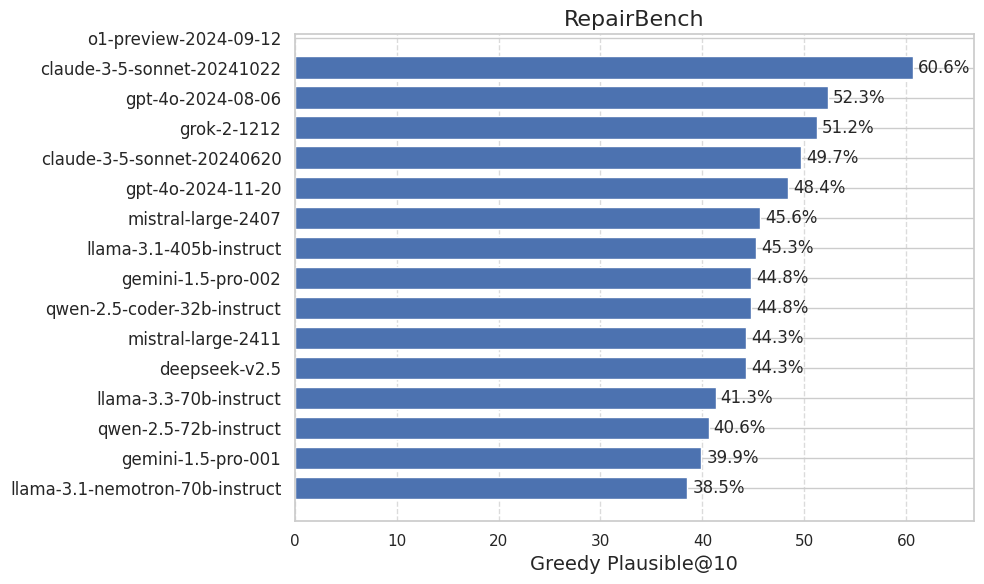

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the DataFrame by 'total_greedy_plausible@10' in descending order
df_sorted = df.sort_values(by='total_greedy_plausible@10', ascending=True)

# Set a style
sns.set(style="whitegrid")

# Create a horizontal bar plot with a single color
plt.figure(figsize=(10, 6))
bars = plt.barh(df_sorted['name'], df_sorted['total_greedy_plausible@10'] * 100, align="center", height=0.75)  # Reduced height

# Set labels and title with improved font size and bold text
plt.xlabel('Greedy Plausible@10', fontsize=14)
plt.title('RepairBench', fontsize=16)

# Add text annotations to display the exact score at the end of each bar with some space and bold text
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.1f}%', va='center', fontsize=12)

# Adjust x-axis limits to provide extra space on the right side
plt.xlim(0, df_sorted['total_greedy_plausible@10'].max() * 100 + 6)

# Add a grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Make the names bold
plt.yticks(fontsize=12)

# Adjust layout to make room for the labels
plt.tight_layout()

# Save as pdf
plt.savefig('box-plot-greedy-plausible@10.pdf', format='pdf', bbox_inches='tight')
plt.savefig('box-plot-greedy-plausible@10.png', format='png', bbox_inches='tight')

# Display the plot
plt.show()